In [137]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [138]:
files = os.listdir()
csv_files = [file for file in files if file.endswith(".csv")]

In [247]:
combined_data = pd.DataFrame()

for csv_file in csv_files:
    file_path = os.path.join(csv_file)
    df = pd.read_csv(file_path)
    if csv_file == "Suntec_City.csv":
        df["occupancy_diff"] = df["carparkOccupancy"].diff().abs()
        sorted_df = df.sort_values(by="occupancy_diff", ascending=False)
        top_3_highest_diff = sorted_df.head(3)
        start_diff_index = top_3_highest_diff.index[0]
        end_diff_index = top_3_highest_diff.index[1]

        # Subtract the diff value from the row with the maximum diff onwards
        highest_diff = top_3_highest_diff["occupancy_diff"].max()
        df.loc[
            start_diff_index : end_diff_index - 1, "carparkOccupancy"
        ] -= highest_diff

        diff_after = (
            df["carparkOccupancy"].iloc[end_diff_index]
            - df["carparkOccupancy"].iloc[end_diff_index - 1]
        )

        df.loc[end_diff_index:, "carparkOccupancy"] -= diff_after

    combined_data = pd.concat([combined_data, df])

    combined_data["timestamp"] = pd.to_datetime(
        combined_data["timestamp"], dayfirst=True
    )
    combined_data["time"] = combined_data["timestamp"].dt.strftime("%H:%M")
    combined_data["timestamp"] = combined_data["timestamp"]

    grouped_data = combined_data.groupby("name")

In [266]:
avg_df = pd.DataFrame()
i = 1

for _, data in grouped_data:
    if "time" not in avg_df.columns:
        avg_df["time"] = data["time"]
    avg_df["carparkOccupancy" + str(i)] = data["carparkOccupancy"]
    i += 1
    

avg_df.set_index("time", inplace=True)  
carparkOcc_cols = [col for col in avg_df.columns if "carparkOccupancy" in col]
avg_df["carparkOccupancy_mean"] = avg_df[carparkOcc_cols].mean(axis=1).astype(int)


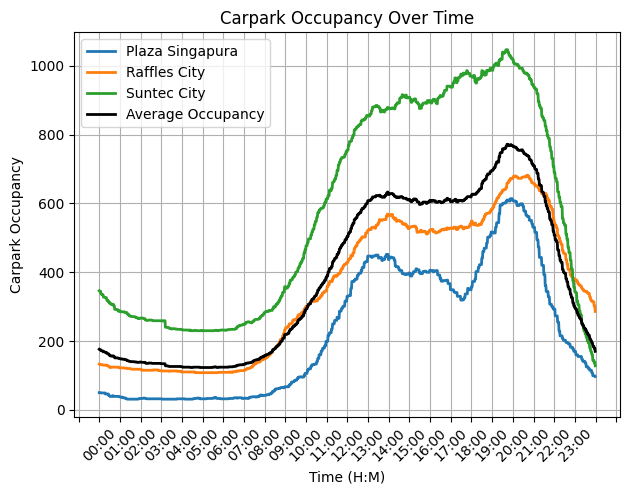

In [267]:
for group, data in grouped_data:
    plt.plot(
        data["time"],
        data["carparkOccupancy"],
        "-",
        lw=2,
        label=f"{group}",
    )

plt.plot(
    avg_df.index,
    avg_df["carparkOccupancy_mean"],
    "-",
    lw=2,
    label="Average Occupancy",
    color="black",
)

ax = plt.gca()
loc = plticker.MultipleLocator(base=60.0)
ax.xaxis.set_major_locator(loc)

plt.xlabel("Time (H:M)")
plt.ylabel("Carpark Occupancy")
plt.title("Carpark Occupancy Over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Find the distribution on avg car occupancy


In [295]:
avg_df['carparkOccupancy_diff'] = avg_df['carparkOccupancy_mean'].diff()

# Calculate the car arrival rate as the difference in occupancy divided by the time interval (in minutes)
# You may need to adjust the time interval based on your data's time step
time_interval_minutes = 1  # Assuming the data is in 1-minute intervals
avg_df['car_arrival_rate'] = avg_df['carparkOccupancy_diff'] / time_interval_minutes

# Fill NaN values in the first row with 0 (since there's no previous data to calculate the difference)
avg_df['car_arrival_rate'].fillna(0, inplace=True)

# Now, your DataFrame 'avg_df' will contain the car arrival rate as a new column
avg_df[["carparkOccupancy_mean","car_arrival_rate"]].loc["07:00":"08:00"]
avg_df[["carparkOccupancy_mean","car_arrival_rate"]].to_csv('out.csv')

/var/folders/mv/5ggb5y_52ds6zk3_3t3rqbjc0000gn/T/ipykernel_12744/7502607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_range_df[time_range_df < 0] = 0
/var/folders/mv/5ggb5y_52ds6zk3_3t3rqbjc0000gn/T/ipykernel_12744/7502607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_range_df[time_range_df < 0] = 0


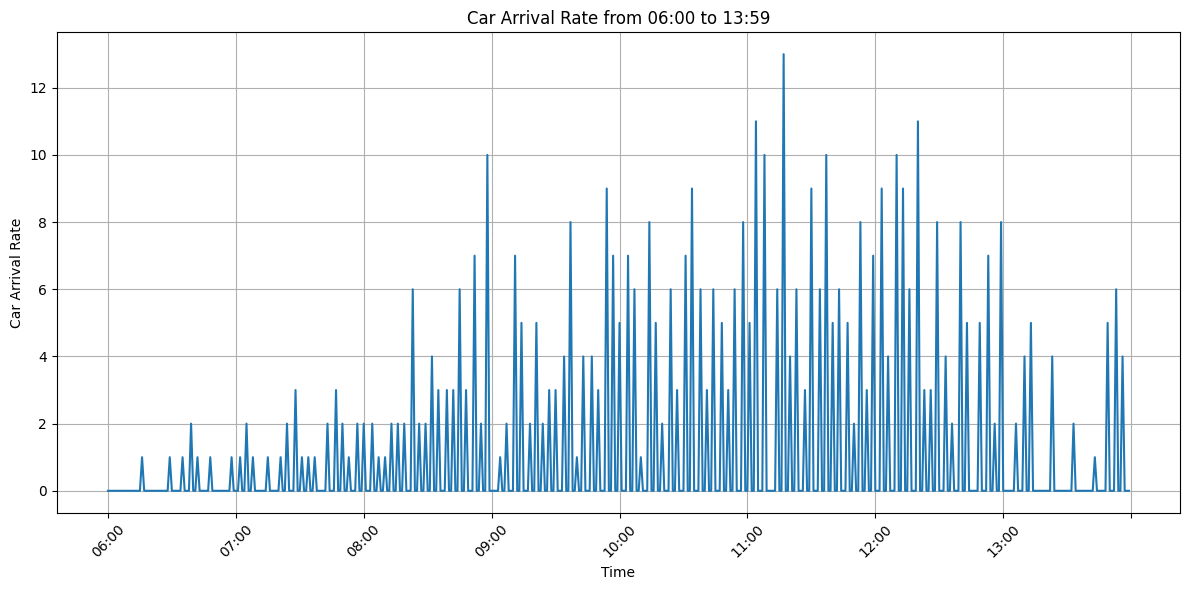

In [309]:
# Filter the DataFrame for the desired time range
time_range = ("06:00","13:59")
time_range_df = avg_df.loc[time_range[0]: time_range[1]]

time_range_df[time_range_df < 0] = 0

# Plot the car arrival rate
plt.figure(figsize=(12, 6))
plt.plot(time_range_df.index, time_range_df['car_arrival_rate'])
plt.title('Car Arrival Rate from %s to %s' %(time_range))
plt.xlabel('Time')
plt.ylabel('Car Arrival Rate')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
loc = plticker.MultipleLocator(base=60.0)
ax.xaxis.set_major_locator(loc)
# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

time_range_df.to_csv("morning.csv")


- 1st slice: 0 to 6 Hours  
- 2nd slice: 6 to 14 Hours
- 3rd slice: 14 to 18 Hours
- 4th slice: 18 to 24 Hours

In [310]:
time_range_df["car_arrival_rate"]

time
06:00    0.0
06:01    0.0
06:02    0.0
06:03    0.0
06:04    0.0
        ... 
13:55    0.0
13:56    4.0
13:57    0.0
13:58    0.0
13:59    0.0
Name: car_arrival_rate, Length: 480, dtype: float64